In [1]:
# Insert Stock Tickers Here
import datetime

startdate = '2020-4-1'


tickers=[
'VVAR3.SA',
]
    

In [2]:
#Packages

import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import yfinance as yf
import datetime as dt
import statsmodels.api as sm
import talib

#Functions

def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2


def ADX(DF,n):
    "function to calculate ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX']=np.array(ADX)
    return df2['ADX']

def rsi(df, n):
    "function to calculate RSI"
    delta = df["Adj Close"].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    return 100 - 100 / (1+rs)

def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["Adj Close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["Adj Close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    return df


def slope(ser,n):
    "function to calculate the slope of regression line for n consecutive points on a plot"
    ser = (ser - ser.min())/(ser.max() - ser.min())
    x = np.array(range(len(ser)))
    x = (x - x.min())/(x.max() - x.min())
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y_scaled = ser[i-n:i]
        x_scaled = x[:n]
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)



sec_data_final = pd.DataFrame()

for t in tickers: 
    try:
            sec_data = pd.DataFrame()
            sec_data = wb.DataReader(t, data_source='yahoo', start = startdate)#,session=session)
            sec_data.reset_index(level=0, inplace=True)
            
            sec_data['LastPrice'] = sec_data['Adj Close'].shift(1)
            
            sec_data['PctReturn'] = ( sec_data['Adj Close']/sec_data['LastPrice'] )-1
            
            sec_data['LogReturn'] = np.log(sec_data['Adj Close'] / sec_data['Adj Close'].shift(1))
            
            sec_data['Body'] = abs(sec_data['Adj Close']-sec_data['Open'])
            sec_data['Shadow_Lower'] = np.where(sec_data['Adj Close']>=sec_data['Open'],sec_data['Open']-sec_data['Low'],sec_data['Adj Close']-sec_data['Low'] )
            sec_data['Shadow_Upper'] = np.where(sec_data['Adj Close']>=sec_data['Open'],sec_data['High']-sec_data['Adj Close'],sec_data['High']-sec_data['Open'] )
            
            sec_data['Body_Relative'] = (abs(sec_data['Adj Close']-sec_data['Open'])/(abs(sec_data['Adj Close']+sec_data['Open'])/2))
            
            sec_data['Shadow_Lower_Relative'] = sec_data['Shadow_Lower']/sec_data['Body']
            sec_data['Shadow_Upper_Relative'] = sec_data['Shadow_Upper']/sec_data['Body']
            sec_data['Volatility_Anual'] = sec_data['LogReturn'].rolling(window=252).std()*np.sqrt(252)
            sec_data['Volatility_Month'] = sec_data['LogReturn'].rolling(window=21).std()*np.sqrt(252)      
            
            sec_data['Last_Returns_10'] = sec_data['LogReturn'].rolling(window=10).sum()
                        
            sec_data['Trend5'] = slope(sec_data['Adj Close'],5)
            sec_data['Trend9'] = slope(sec_data['Adj Close'],9)
            sec_data['Trend14'] = slope(sec_data['Adj Close'],14)
            sec_data['Trend20'] = slope(sec_data['Adj Close'],20)
            
            sec_data['Momentum_10'] = sec_data['Adj Close']-sec_data['Adj Close'].shift(9)  
            sec_data['Momentum_10_SMA_9'] = sec_data['Momentum_10'].rolling(window=9).mean()
            
            sec_data['OBVsign'] = np.where(sec_data['Adj Close']<sec_data['LastPrice'],-1,1)*sec_data['Volume']
            sec_data['OBV'] = sec_data['OBVsign'].cumsum()
            
            sec_data['OBV_Trend5'] = slope(sec_data['OBV'],5)
            sec_data['OBV_Trend14'] = slope(sec_data['OBV'],14)
            
            sec_data['ADX14'] = ADX(sec_data,14) 
            sec_data['ADX14_Trend5'] = slope(sec_data['ADX14'],5)
            sec_data['ADX14_Trend14'] = slope(sec_data['ADX14'],14)
            
            sec_data['ATR14'] = ATR(sec_data,14)['ATR']
            sec_data['ATR14_Trend5'] = slope(sec_data['ATR14'],5)
            sec_data['ATR14_Trend14'] = slope(sec_data['ATR14'],14)      
            
             
            sec_data['SMA3'] = sec_data['Adj Close'].rolling(window=3).mean()                            
            sec_data['SMA8'] = sec_data['Adj Close'].rolling(window=8).mean()
            sec_data['SMA20'] = sec_data['Adj Close'].rolling(window=20).mean()
            sec_data['SMA20_STD'] = sec_data['Adj Close'].rolling(window=20).std()
            sec_data['SMA200'] = sec_data['Adj Close'].rolling(window=200).mean()            
                     
            sec_data['Bollinger_Sup'] = sec_data['SMA20']+2*sec_data['SMA20_STD']
            sec_data['Bollinger_Inf'] = sec_data['SMA20']-2*sec_data['SMA20_STD']
            
            sec_data['Bollinger_Sup%'] = (sec_data['Adj Close']-sec_data['Bollinger_Sup'])/sec_data['Adj Close']
            sec_data['Bollinger_Inf%'] = (sec_data['Adj Close']-sec_data['Bollinger_Inf'])/sec_data['Adj Close']
            
            sec_data['Bollinger_Spread'] = (sec_data['Bollinger_Sup']-sec_data['Bollinger_Inf'])/sec_data['SMA20']
            sec_data['Bollinger_Spread_Trend5'] = slope(sec_data['Bollinger_Spread'],5)
            sec_data['Bollinger_Spread_Trend14'] = slope(sec_data['Bollinger_Spread'],14)
            
            sec_data['IFR_2'] = rsi(sec_data,2)
            sec_data['IFR'] = rsi(sec_data,9)
            
            sec_data['IFR_Trend5'] = slope(sec_data['IFR'],5)
            sec_data['IFR_Trend14'] = slope(sec_data['IFR'],14)
            
            sec_data['EMA9'] = sec_data['Adj Close'].ewm(span=9,adjust=False).mean()
            sec_data['EMA9%'] = (sec_data['Adj Close']-sec_data['EMA9'])/sec_data['Adj Close']
            
            sec_data['EMA9_Trend9'] = slope(sec_data['EMA9'],9)
            
            sec_data['EMA12'] = sec_data['Adj Close'].ewm(span=12,adjust=False).mean()
            sec_data['EMA21'] = sec_data['Adj Close'].ewm(span=21,adjust=False).mean()
            sec_data['EMA21%'] = (sec_data['Adj Close']-sec_data['EMA21'])/sec_data['Adj Close']
            sec_data['EMA26'] = sec_data['Adj Close'].ewm(span=26,adjust=False).mean()
            
            sec_data['EMA50'] = sec_data['Adj Close'].ewm(span=50,adjust=False).mean()
            sec_data['EMA50%'] = (sec_data['Adj Close']-sec_data['EMA50'])/sec_data['Adj Close']
            
            sec_data['EMA50_Trend14'] = slope(sec_data['EMA50'],14)
                        
            sec_data['EMA200'] = sec_data['Adj Close'].ewm(span=200,adjust=False).mean()
            sec_data['EMA200%'] = (sec_data['Adj Close']-sec_data['EMA200'])/sec_data['Adj Close']
            
            sec_data['MACD'] = sec_data['EMA12']-sec_data['EMA26']
            sec_data['MACD_Signal'] =  sec_data['MACD'].ewm(span=9,adjust=False).mean()
            sec_data['MACD_Hist'] = sec_data['MACD'] - sec_data['MACD_Signal']          
            
            sec_data['MACD_Hist_Trend5'] = slope(sec_data['MACD_Hist'],5)
            sec_data['MACD_Hist_Trend14'] = slope(sec_data['MACD_Hist'],14)
                       
            sec_data['SMA9_VOLUME'] = sec_data['Volume'].rolling(window=9).mean()
            sec_data['SMA20_VOLUME'] = sec_data['Volume'].rolling(window=20).mean()
            sec_data['SMA200_VOLUME'] = sec_data['Volume'].rolling(window=200).mean()
            
            sec_data['SMA9_VOLUME%'] = (sec_data['Volume']/sec_data['SMA9_VOLUME']) - 1
            sec_data['SMA20_VOLUME%'] = (sec_data['Volume']/sec_data['SMA20_VOLUME']) - 1
            
            sec_data['STOCHASTIC_K_FAST'] = 100 * (sec_data['Adj Close'] - sec_data['Low'].rolling( window = 14 ).min())/(sec_data['High'].rolling( window = 14 ).max() - sec_data['Low'].rolling( window = 14 ).min())
            sec_data['STOCHASTIC_D_FAST'] = sec_data['STOCHASTIC_K_FAST'].rolling(window = 3).mean()
            
            sec_data['STOCHASTIC_K_SLOW'] = sec_data['STOCHASTIC_D_FAST']
            sec_data['STOCHASTIC_D_SLOW'] = sec_data['STOCHASTIC_K_SLOW'].rolling(window = 3).mean()
            
            sec_data['STO_Trend5'] = slope(sec_data['STOCHASTIC_D_SLOW'],5)
            sec_data['STO_Trend14'] = slope(sec_data['STOCHASTIC_D_SLOW'],14)
            
            #### SETUPS ###############################################################################
            
            sec_data['#Romp_EMA9_Bear'] = np.where((sec_data['EMA9_Trend9']>2) & (sec_data['Adj Close']<sec_data['EMA9']),1,0)
            sec_data['#Romp_EMA9_Bull'] = np.where((sec_data['EMA9_Trend9']<-2) & (sec_data['Adj Close']>sec_data['EMA9']),1,0)
            sec_data['#Romp_EMA9'] = sec_data['#Romp_EMA9_Bear'] + sec_data['#Romp_EMA9_Bull']
            
            sec_data['#Romp_EMA50_Bear'] = np.where((sec_data['EMA50_Trend14']>2) & (sec_data['Adj Close']<sec_data['EMA50']),1,0)
            sec_data['#Romp_EMA50_Bull'] = np.where((sec_data['EMA50_Trend14']<-2) & (sec_data['Adj Close']>sec_data['EMA50']),1,0)
            sec_data['#Romp_EMA50'] = sec_data['#Romp_EMA50_Bear'] + sec_data['#Romp_EMA50_Bull']
            
            sec_data['#MACDH_Change_Bear'] = np.where((sec_data['MACD_Hist'].shift(1)>0)&(sec_data['MACD_Hist']<0),-1,0)
            sec_data['#MACDH_Change_Bull'] = np.where((sec_data['MACD_Hist'].shift(1)<0)&(sec_data['MACD_Hist']>0),1,0) 
            sec_data['#MACDH_Change'] =  sec_data['#MACDH_Change_Bear'] + sec_data['#MACDH_Change_Bull']
            
            sec_data['#EMA9_Change_Bear'] = np.where((sec_data['EMA9_Trend9']>0)&(sec_data['EMA9']<sec_data['EMA9'].shift(1)),-1,0)
            sec_data['#EMA9_Change_Bull'] = np.where((sec_data['EMA9_Trend9']<0)&(sec_data['EMA9']>sec_data['EMA9'].shift(1)),1,0)
            sec_data['#EMA9_Change'] = sec_data['#EMA9_Change_Bear'] + sec_data['#EMA9_Change_Bull']
            
            sec_data['#Trend_Divergence_Bear'] =  np.where((sec_data['Trend5']>0) & (sec_data['IFR_Trend5']<0) & (sec_data['OBV_Trend5']<0),-1,0)
            sec_data['#Trend_Divergence_Bull'] =  np.where((sec_data['Trend5']<0)& (sec_data['IFR_Trend5']>0) & (sec_data['OBV_Trend5']>0),1,0)
            sec_data['#Trend_Divergence'] = sec_data['#Trend_Divergence_Bear']+sec_data['#Trend_Divergence_Bull']
            
            sec_data['#IFR2_Bear'] = np.where((sec_data['EMA9_Trend9']<-2)&(sec_data['IFR_2']>90),1,0)
            sec_data['#IFR2_Bull'] = np.where((sec_data['EMA9_Trend9']>2)&(sec_data['IFR_2']<10),1,0)
            sec_data['#IFR2'] = sec_data['#IFR2_Bear'] + sec_data['#IFR2_Bull']
            
            sec_data['#AGULHADA'] = np.where( 
                (sec_data['SMA3']>sec_data['SMA8']) & 
                (sec_data['SMA8']>sec_data['SMA20']) & 
                (sec_data['SMA20'].shift(2) > sec_data['SMA8'].shift(2)) &
                (sec_data['SMA8'].shift(2) > sec_data['SMA3'].shift(2)),1,0)
            
            sec_data['#INSIDEBAR_Bull'] = np.where(
                (sec_data['Adj Close']<sec_data['Adj Close'].shift(1))&
                (sec_data['Adj Close']>sec_data['Open'].shift(1))&
                (sec_data['High']<sec_data['High'].shift(1))&
                (sec_data['Low']>sec_data['Low'].shift(1))&
                (sec_data['Open']>sec_data['Open'].shift(1))&
                (sec_data['Open']<sec_data['Adj Close'].shift(1)),1,0)
            
            sec_data['#INSIDEBAR_Bear'] = np.where(
                (sec_data['Adj Close']>sec_data['Adj Close'].shift(1))&
                (sec_data['Adj Close']<sec_data['Open'].shift(1))&
                (sec_data['High']<sec_data['High'].shift(1))&
                (sec_data['Low']>sec_data['Low'].shift(1))&
                (sec_data['Open']<sec_data['Open'].shift(1))&
                (sec_data['Open']>sec_data['Adj Close'].shift(1)),1,0)
            
            sec_data['#INSIDEBAR'] = sec_data['#INSIDEBAR_Bull'] + sec_data['#INSIDEBAR_Bear']
                        
            sec_data['Stock'] = t[:-3]
            
            sec_data_final = pd.concat([sec_data_final,sec_data])
        
    except:
            print(t)


sec_data_final.to_csv('bovespa_diario.csv', sep =';', index=False)



In [3]:
pd.set_option('display.max_columns', None)
sec_data_final

,Date,High,Low,Open,Close,Volume,Adj Close,LastPrice,PctReturn,LogReturn,Body,Shadow_Lower,Shadow_Upper,Body_Relative,Shadow_Lower_Relative,Shadow_Upper_Relative,Volatility_Anual,Volatility_Month,Last_Returns_10,Trend5,Trend9,Trend14,Trend20,Momentum_10,Momentum_10_SMA_9,OBVsign,OBV,OBV_Trend5,OBV_Trend14,ADX14,ADX14_Trend5,ADX14_Trend14,ATR14,ATR14_Trend5,ATR14_Trend14,SMA3,SMA8,SMA20,SMA20_STD,SMA200,Bollinger_Sup,Bollinger_Inf,Bollinger_Sup%,Bollinger_Inf%,Bollinger_Spread,Bollinger_Spread_Trend5,Bollinger_Spread_Trend14,IFR_2,IFR,IFR_Trend5,IFR_Trend14,EMA9,EMA9%,EMA9_Trend9,EMA12,EMA21,EMA21%,EMA26,EMA50,EMA50%,EMA50_Trend14,EMA200,EMA200%,MACD,MACD_Signal,MACD_Hist,MACD_Hist_Trend5,MACD_Hist_Trend14,SMA9_VOLUME,SMA20_VOLUME,SMA200_VOLUME,SMA9_VOLUME%,SMA20_VOLUME%,STOCHASTIC_K_FAST,STOCHASTIC_D_FAST,STOCHASTIC_K_SLOW,STOCHASTIC_D_SLOW,STO_Trend5,STO_Trend14,#Romp_EMA9_Bear,#Romp_EMA9_Bull,#Romp_EMA9,#Romp_EMA50_Bear,#Romp_EMA50_Bull,#Romp_EMA50,#MACDH_Change_Bear,#MACDH_Change_Bull,#MACDH_Change,#EMA9_Change_Bear,#EMA9_Change_Bull,#EMA9_Change,#Trend_Divergence_Bear,#Trend_Divergence_Bull,#Trend_Divergence,#IFR2_Bear,#IFR2_Bull,#IFR2,#AGULHADA,#INSIDEBAR_Bull,#INSIDEBAR_Bear,#INSIDEBAR,Stock
0,2020-04-01,4.94,4.56,4.66,4.65,100418200.0,4.65,NaN,NaN,NaN,0.01,0.090000,0.28,0.002148,9.000238,28.000715,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,100418200.0,1.004182e+08,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,4.650000,0.000000,0.000000,4.650000,4.650000,0.000000,4.650000,4.650000,0.000000,0.000000,4.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VVAR3
1,2020-04-02,4.78,4.32,4.71,4.38,74757000.0,4.38,4.65,-0.058065,-0.059818,0.33,0.060000,0.07,0.072607,0.181818,0.212122,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,-74757000.0,2.566120e+07,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,4.596000,-0.049315,0.000000,4.608462,4.625455,-0.056040,4.630000,4.639412,-0.059226,0.000000,4.647314,-0.061030,-0.021538,-0.004308,-0.017231,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VVAR3
2,2020-04-03,4.37,3.96,4.36,4.10,94686300.0,4.10,4.38,-0.063927,-0.066062,0.26,0.140000,0.01,0.061466,0.538461,0.038461,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,-94686300.0,-6.902510e+07,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,4.376667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,4.496800,-0.096781,0.000000,4.530237,4.577686,-0.116509,4.590741,4.618258,-0.126405,0.000000,4.641868,-0.132163,-0.060504,-0.015547,-0.044957,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VVAR3
3,2020-04-06,4.58,4.08,4.45,4.36,89393700.0,4.36,4.10,0.063415,0.061485,0.09,0.280000,0.13,0.020431,3.111125,1.444451,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,89393700.0,2.036860e+07,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,4.280000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,58.646629,NaN,0.000000,0.000000,4.469440,-0.025101,0.000000,4.504047,4.557896,-0.045389,4.573649,4.608131,-0.056911,0.000000,4.639063,-0.064005,-0.069602,-0.026358,-0.043244,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,VVAR3
4,2020-04-07,4.76,4.40,4.72,4.42,79731500.0,4.42,4.36,0.013761,0.013668,0.30,0.020000,0.04,0.065645,0.066667,0.133335,NaN,NaN,NaN,-38.610998,0.000000,0.000000,0.000000,NaN,NaN,79731500.0,1.001001e+08,-3.181403,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,4.293333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,65.625001,NaN,NaN,0.000000,4.459

In [4]:
last_date = sec_data_final[['Date']].max()

sec_last_date = sec_data_final[(sec_data_final['Date'] == sec_data_final['Date'].max())]

In [5]:
sec_last_date.to_csv('bovespa_diario_last_date.csv', sep =';', index=False)

In [6]:
sec_data_final['Next Day Max Value']=sec_data_final['High'].shift(-1)
sec_data_final['Next Day Max Return']=(sec_data_final['High'].shift(-1)/sec_data_final['Adj Close'])-1
sec_data_final['BUY'] = np.where((sec_data_final['Next Day Max Return']>=0.03) & (sec_data['Adj Close']<sec_data['EMA9']),1,0)

In [7]:
sec_data_final.to_csv('vvar3test.csv', sep =';', index=False)

In [8]:
sec_tree = sec_data_final[["IFR_2","Bollinger_Sup%","Bollinger_Inf%","EMA9%","BUY"]].dropna()

In [9]:
sec_tree.describe()



,IFR_2,Bollinger_Sup%,Bollinger_Inf%,EMA9%,BUY
count,268.000000,268.000000,268.000000,268.000000,268.000000
mean,51.136517,-0.104451,0.132167,0.005281,0.171642
std,25.419130,0.086265,0.147210,0.046233,0.377774
min,4.952311,-0.446375,-0.041097,-0.117633,0.000000
25%,30.476364,-0.156478,0.040740,-0.025116,0.000000
50%,51.875157,-0.100138,0.078545,0.001089,0.000000
75%,70.558440,-0.035331,0.149729,0.027050,0.000000
max,99.670147,0.051913,0.678562,0.142842,1.000000


In [10]:
sec_tree.loc[(sec_tree.BUY == 1)].iloc[1:20]

,IFR_2,Bollinger_Sup%,Bollinger_Inf%,EMA9%,BUY
25,29.699974,-0.232384,0.483960,-0.007173,1
26,20.119747,-0.272564,0.416891,-0.036837,1
29,32.801671,-0.246233,0.314666,-0.023961,1
30,47.877473,-0.213378,0.295452,-0.001621,1
58,12.341832,-0.135535,0.099006,-0.027572,1
79,25.167792,-0.159770,0.258659,-0.026446,1
83,34.974450,-0.137121,0.203155,-0.011871,1
91,10.523755,-0.174681,-0.000209,-0.054343,1
94,17.152864,-0.213817,-0.009615,-0.065623,1
112,18.304860,-0.193781,0.033926,-0.047588,1


In [11]:
sec_tree.loc[(sec_tree.BUY == 1)][["IFR_2","BUY"]]

,IFR_2,BUY
24,27.610975,1
25,29.699974,1
26,20.119747,1
29,32.801671,1
30,47.877473,1
58,12.341832,1
79,25.167792,1
83,34.974450,1
91,10.523755,1
94,17.152864,1


In [12]:
samples = sec_tree.loc[(sec_tree.BUY == 1)]["IFR_2"].count()

In [13]:
sec_buy = sec_tree.loc[(sec_tree.BUY == 1)].sample(samples)
sec_notbuy = sec_tree.loc[(sec_tree.BUY == 0)].sample(samples)
frames = [sec_buy,sec_notbuy]
result = pd.concat(frames)

In [14]:
result

,IFR_2,Bollinger_Sup%,Bollinger_Inf%,EMA9%,BUY
239,23.063381,-0.106586,0.017338,-0.042149,1
160,44.323428,-0.119192,0.068181,-0.008838,1
231,46.523987,-0.268347,0.111567,-0.016644,1
146,21.743911,-0.213992,0.015682,-0.082180,1
144,6.451838,-0.190533,0.034787,-0.091535,1
...,...,...,...,...,...
180,7.818599,-0.172680,0.013856,-0.045436,0
43,91.292255,-0.046804,0.514833,0.096790,0
37,97.548346,0.051913,0.372553,0.142583,0
219,29.246215,-0.193351,0.014452,-0.044969,0


In [15]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [57]:
features = result[["IFR_2","Bollinger_Sup%","Bollinger_Inf%","EMA9%"]]
target = result.BUY.astype("category")

In [58]:
target

239    1
160    1
231    1
146    1
144    1
      ..
180    0
43     0
37     0
219    0
254    0
Name: BUY, Length: 92, dtype: category
Categories (2, int64): [0, 1]

In [17]:
print(result.corr())

                   IFR_2  Bollinger_Sup%  Bollinger_Inf%     EMA9%       BUY
IFR_2           1.000000        0.686994        0.593737  0.920291 -0.632205
Bollinger_Sup%  0.686994        1.000000        0.256939  0.741822 -0.546153
Bollinger_Inf%  0.593737        0.256939        1.000000  0.727091 -0.258084
EMA9%           0.920291        0.741822        0.727091  1.000000 -0.553416
BUY            -0.632205       -0.546153       -0.258084 -0.553416  1.000000


In [59]:
featureTrain, featureTest, targetTrain, targetTest = train_test_split(features,target,test_size = .2)

In [73]:
clf = DecisionTreeClassifier(max_depth = 1)

In [71]:
targetTrain

182    1
254    0
38     0
86     0
119    0
      ..
53     0
273    0
170    1
29     1
24     1
Name: BUY, Length: 73, dtype: category
Categories (2, int64): [0, 1]

In [62]:
print(clf)

DecisionTreeClassifier()


In [74]:
modelo = clf.fit(featureTrain, targetTrain)

In [75]:
previsoes = modelo.predict(featureTest)

In [76]:
print(confusion_matrix(targetTest, previsoes))

[[11  3]
 [ 2  3]]


In [77]:
print(accuracy_score(targetTest, previsoes))

0.7368421052631579


In [78]:
import graphviz
from sklearn.tree import export_graphviz

In [68]:
!dot -Tpng tree.dot -o tree.png

Error: dot: can't open tree.dot: No such file or directory


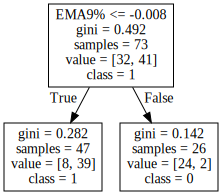

In [79]:
arquivo = "D:/tree.dot"
export_graphviz(modelo, out_file = arquivo, feature_names=["IFR_2","Bollinger_Sup%","Bollinger_Inf%","EMA9%"], class_names = ["0","1"])
with open(arquivo) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)